# DATA20001 Deep Learning - Group Project
## Image project

**Due Thursday, December 13, before 23:59.**

The task is to learn to assign the correct labels to a set of images.  The images are originally from a photo-sharing site and released under Creative Commons-licenses allowing sharing.  The training set contains 20 000 images. We have resized them and cropped them to 128x128 to make the task a bit more manageable.

We're only giving you the code for downloading the data. The rest you'll have to do yourselves.

Some comments and hints particular to the image project:

- One image may belong to many classes in this problem, i.e., it's a multi-label classification problem. In fact there are images that don't belong to any of our classes, and you should also be able to handle these correctly. Pay careful attention to how you design the outputs of the network (e.g., what activation to use) and what loss function should be used.

- As the dataset is pretty imbalanced, don't focus too strictly on the outputs being probabilistic. (Meaning that the right threshold for selecting the label might not be 0.5.)

- Image files can be loaded as numpy matrices for example using `imread` from `matplotlib.pyplot`. Most images are color, but a few grayscale. You need to handle the grayscale ones somehow as they would have a different number of color channels (depth) than the color ones.

- In the exercises we used e.g., `torchvision.datasets.MNIST` to handle the loading of the data in suitable batches. Here, you need to handle the dataloading yourself.  The easiest way is probably to create a custom `Dataset`. [See for example here for a tutorial](https://github.com/utkuozbulak/pytorch-custom-dataset-examples).

In [1]:
! pip install torch torchvision torchsummary

## Download the data

In [0]:
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
import zipfile

In [0]:
train_path = 'train'
dl_file = 'dl2018-image-proj.zip'
dl_url = 'https://users.aalto.fi/mvsjober/misc/'

zip_path = os.path.join(train_path, dl_file)
if not os.path.isfile(zip_path):
    download_url(dl_url + dl_file, root=train_path, filename=dl_file, md5=None)

with zipfile.ZipFile(zip_path) as zip_f:
    zip_f.extractall(train_path)
    #os.unlink(zip_path)

In [4]:
if torch.cuda.is_available():
    print('Using GPU!')
    device = torch.device('cuda')
else:
    print('Using CPU')
    device = torch.device('cpu')

Using GPU!


The above command downloaded and extracted the data files into the `train` subdirectory.

The images can be found in `train/images`, and are named as `im1.jpg`, `im2.jpg` and so on until `im20000.jpg`.

The class labels, or annotations, can be found in `train/annotations` as `CLASSNAME.txt`, where CLASSNAME is one of the fourteen classes: *baby, bird, car, clouds, dog, female, flower, male, night, people, portrait, river, sea,* and *tree*.

Each annotation file is a simple text file that lists the images that depict that class, one per line. The images are listed with their number, not the full filename. For example `5969` refers to the image `im5969.jpg`.

## Your stuff goes here ...

In [0]:
import os
from os import listdir
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random as rd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
img_path = "./train/images/"
labels_path = "./train/annotations/"

In [6]:
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

Get all annotations & images paths

In [0]:
images_path = "train/images/" 
image_files = [(images_path+f) for f in os.listdir(images_path) \
                if os.path.isfile(os.path.join(images_path, f))]
grayscale_images = []
for current_img_path in image_files:
    current_img_vector =  plt.imread( current_img_path )
    if len(current_img_vector.shape)==2: # If shape is (128, 128) (no color channels)
        filename_without_extension = os.path.basename(current_img_path)[:-4] # :-4 to drop the extension
        img_num = filename_without_extension[2:] # drop the heading "im"
        grayscale_images+=[img_num]
del image_files

In [0]:
data=grayscale_images
labels = [[] for _ in range(len(data))] # Empty list of labels
annotations_path = "train/annotations/"
annotations_files = [(annotations_path+f) for f in os.listdir(annotations_path) \
        if os.path.isfile(os.path.join(annotations_path, f))]
for file in annotations_files:
    label = os.path.basename(file)[:-4] # :-4 to drop the extension
    with open(file) as f: # file is the name of the label currently read
        img_nums = f.read().split()
    for img_num in img_nums:
        if img_num not in data:
            continue
        labels[data.index(img_num)].append(label)

In [0]:
class OneHotTransformer:
    def __init__(self):
        annotations_files = [(annotations_path+f) for f in os.listdir(annotations_path) \
                    if os.path.isfile(os.path.join(annotations_path, f))]
        self.vocabulary = []
        for file in annotations_files:
            label = os.path.basename(file)[:-4] # :-4 to drop the extension
            self.vocabulary.append(label)
    def toOneHot(self, labels):
        res = [0]*len(self.vocabulary)
        for i, voc in enumerate(self.vocabulary):
            if voc in labels:
                res[i] = 1
        return np.array(res)
    def toVocabulary(self, onehot):
        res = []
        for i, n in enumerate(onehot):
            if n: res.append(self.vocabulary[i])
        return res
oneHotTransformer = OneHotTransformer()

In [0]:
# Files to pytorch dataset
# Inspired from https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py
from torch.utils.data.dataset import Dataset
from torchvision import datasets, transforms
from PIL import Image

class imageDataset(Dataset):
    def __init__(self, data_basenames, height=128, width=128, transforms=transforms.ToTensor()):
        """
        data_basenames is a list of id of image, such as ["9885", "9886"]
        transforms is a list of transformation. it last element should be transforms.ToTensor()
        """
        def parse_labels(data_paths):
            """ Parse to one hot """
            labels = [[] for _ in range(len(data_paths))] # Empty list of labels
            annotations_path = "train/annotations/"
            annotations_files = [(annotations_path+f) for f in os.listdir(annotations_path) \
                    if os.path.isfile(os.path.join(annotations_path, f))]
            vocabulary = []
            for file in annotations_files:
                label = os.path.basename(file)[:-4] # :-4 to drop the extension
                vocabulary.append(label)
                with open(file) as f: # file is the name of the label currently read
                    img_nums = f.read().split()
                for img_num in img_nums:
                    if img_num not in data_paths:
                        continue
                    labels[data_paths.index(img_num)].append(label)
            return labels
        self.data = data_basenames
        self.labels = parse_labels(data_basenames)
        self.height = height
        self.width = width
        self.transforms = transforms
        self.data_len = len(data_basenames)

    def __getitem__(self, index):
        img_path = "train/images/im" + self.data[index] + ".jpg"
        data = Image.open(img_path)
        if self.transforms is not None:
            img = self.transforms(data)
        #labels = np.array(self.labels[index])
        #print(self.labels[index])
        labels = self.labels[index]
        one_hot_labels = oneHotTransformer.toOneHot(labels)
        return img, one_hot_labels

    def __len__(self):
        return self.data_len

    
import random
random.shuffle(grayscale_images) # So we make sure test data has all kinds of label, in case
                                 # the repartition is not even according to label names

batch_size = 16

# 80% train, 20% test
index_cut =  int(len(grayscale_images)*0.8)
train_dataset = imageDataset(grayscale_images[:index_cut])
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)
test_dataset = imageDataset(grayscale_images[index_cut:])
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [0]:
data, target = next(train_loader.__iter__()) # Iteration works!

Model start

First, simple CNN architecture( exercise 3)

In [48]:
class sim_cnn_v1(nn.Module):
    def __init__(self, nclass = 14):
        super(sim_cnn_v1,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1,16,kernel_size = 3,padding = 0,stride = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32,kernel_size = 3,padding = 0,stride = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.fc1 = nn.Linear(30*30*32, 30*32)
        self.fc2 = nn.Linear(30*32, nclass)
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0),-1)
        out = F.relu(self.fc1(out))
        output = self.fc2(out)
        return output
        
model = sim_cnn_v1().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #Adam
criterion = nn.MultiLabelSoftMarginLoss() 
print(model)
from torchsummary import summary
summary(model, (1, 128, 128))

sim_cnn_v1(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=28800, out_features=960, bias=True)
  (fc2): Linear(in_features=960, out_features=14, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 126, 126]             160
       BatchNorm2d-2         [-1, 16, 126, 126]              32
              ReLU-3         [-1, 16, 126, 126]      

In [0]:
class one_layer_cnn(nn.Module):
    def __init__(self, nclass = 14):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1,16,kernel_size = 3,padding = 0,stride = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.fc1 = nn.Linear(16*63*63, nclass)
        
    def forward(self,x):
        out = self.layer1(x)
        out = out.view(out.size(0),-1)
        output = self.fc1(out)
        return torch.sigmoid(output)

In [0]:
class deep_cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(10, stride=3)
        )
        #self.fc1 = nn.Linear(4096, 20)
        self.lastlayer = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(4096//64, 14)
        )
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        #out = self.conv4(out)
        out = out.view(out.size(0),-1)
        out = self.lastlayer(out)
        return F.sigmoid(out)
model = deep_cnn()

In [0]:
# TODO
class lstm(nn.Module):
    pass

Train the model

In [0]:
def train_net(model, epoch, trainLoss, thresh, interval = 10):
    # set model to train
    model.train()
    loss = 0
    #acc = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data = data.to(device) # to GPU
        target = target.float().to(device) # to GPU, ".float()" is improtant, otherwise got error.
        
        # set zero gradient buffer
        optimizer.zero_grad()
        
        # compute the output and Loss
        output = model(data)
        Loss = criterion(output, target)
        
        # compute the accuracy => now done in "validate" function with test dataset
        #predict = torch.sigmoid(output)
        #labels = torch.FloatTensor([[1 if prob >= thresh else 0 for prob in predict[i]] for i in range(len(target))])
        #print(labels)
        #print(target)
        #Acc = len([i for i in range(len(target)) if (target[i].cpu()==labels[i].cpu()).sum() == 14])
        
        # back prop
        Loss.backward()
        
        # update weights
        optimizer.step()
        
        # print information
        if batch_idx % interval == 0:
            print("Train Epoch: {} [{}/{} {:.0f}%]\tLoss: {:.6f}".format(epoch, len(data)*batch_idx, len(train_loader)*len(data), batch_idx/len(train_loader)*100, Loss.data.item()))   
          #print("Train Epoch: {} [{}/{} {:.0f}]\tLoss: {:.6f}\tAccuracy: {:.6f}".format(epoch, len(data)*batch_idx, len(data_loader)*len(data), batch_idx/len(data_loader)*100, Loss.data.item(), Acc/10))
        
        loss += Loss
        #acc += Acc
    loss/=len(train_loader)
    
    trainLoss.append(loss)
    #print(acc/len(train_loader)/interval)

With threshold 0.7

In [63]:
def validate(model, treshold, lossv, accv, precv, recv, verbose=True):
  loss, acc, prec, rec = 0,0,0,0
  for i, sample in enumerate(test_loader):
    inputv, targetv = sample
    inputv = inputv.to(device)
    output = model(inputv)
    
    pred = output.data.gt(treshold) # Activated output
    #loss += criterion(output, target.float().to(device))
    loss += criterion(output, targetv.data.to(device).float()).data.item()
    # confusion matrix (true/false negative/positive)
    tp = (pred + targetv.data.to(device).byte()).eq(2).sum()
    fp = (pred - targetv.data.to(device).byte()).eq(1).sum()
    fn = (pred - targetv.data.to(device).byte()).eq(-1).sum()
    tn = (pred + targetv.data.to(device).byte()).eq(0).sum()
    acc += (tp + tn).float() / (tp + tn + fp + fn)

    if tp+fp!=0:
      prec += tp.float() / (tp + fp)
    else:
      prec += 0.0
    if tp+fn != 0:
      rec += tp.float() / (tp + fn)
    else:
      rec += 0.0
  loss /= len(test_loader)
  acc /= len(test_loader)
  prec /= len(test_loader)
  rec /= len(test_loader)
  lossv.append(loss)
  accv.append(acc)
  precv.append(prec)
  recv.append(rec)
  if verbose:
    print('Validation set: Average loss: {:.4f}, Accuracy: {:.2f}%, Precision: {:.2f}%, Recall: {:.2f}%'.format(
            loss, acc*100, prec*100, rec*100))
    print("\t\tF1 score : {:.2f}%\n".format(100*2*(prec*rec)/(prec+rec)))
lossv, accv, precv, recv = [],[],[],[] # Average loss, accuracy, precision and recall
validate(model, 0.5, lossv, accv, precv, recv)

Validation set: Average loss: 0.9062, Accuracy: 58.16%, Precision: 3.45%, Recall: 12.43%
		F1 score : 5.41%



With threshold 0.5

In [85]:
%%time
#model = one_layer_cnn().to(device)
#model = sim_cnn_v1().to(device)
model = deep_cnn().to(device)
#model = lstm()
treshold = 0.3
epoch = 30

#learning_rate = 0.000001 # for sim_cnn_v1
learning_rate = 0.0001 # for deep_cnn
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) #Adam
criterion = nn.MultiLabelSoftMarginLoss()
#criterion = nn.BCELoss()
train_loss, val_loss = [], []
accuracy, precision, recall = [],[],[]
for i in range(1,1+epoch):
    train_net(model, i, train_loss, treshold)
    validate(model, treshold, val_loss, accuracy, precision, recall)
    
    if i>3:
      prev_delta_loss = abs(val_loss[-2] - train_loss[-2]) 
      delta_loss = abs(val_loss[-1] - train_loss[-1])
      if delta_loss > prev_delta_loss:
        # The model starts to be overfitted
        #if delta_loss<0.01:
        #  break # We consider a 0.01 delta loss good enough
        #elif delta_loss<0.5: 
        #  print("Smaller learning rate!")
        #  learning_rate /= 10 # Dividing the learning rate
        # optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 
        pass

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/1152 0%]	Loss: 0.947424
Train Epoch: 1 [160/1152 14%]	Loss: 0.885052
Train Epoch: 1 [320/1152 28%]	Loss: 0.895141
Train Epoch: 1 [480/1152 42%]	Loss: 0.889068
Train Epoch: 1 [640/1152 56%]	Loss: 0.874282
Train Epoch: 1 [800/1152 69%]	Loss: 0.880040
Train Epoch: 1 [960/1152 83%]	Loss: 0.881786
Train Epoch: 1 [1120/1152 97%]	Loss: 0.861624
Validation set: Average loss: 0.8707, Accuracy: 33.80%, Precision: 10.35%, Recall: 74.99%
		F1 score : 18.19%

Train Epoch: 2 [0/1152 0%]	Loss: 0.874645
Train Epoch: 2 [160/1152 14%]	Loss: 0.865820
Train Epoch: 2 [320/1152 28%]	Loss: 0.852641
Train Epoch: 2 [480/1152 42%]	Loss: 0.831460
Train Epoch: 2 [640/1152 56%]	Loss: 0.839368
Train Epoch: 2 [800/1152 69%]	Loss: 0.839247
Train Epoch: 2 [960/1152 83%]	Loss: 0.856449
Train Epoch: 2 [1120/1152 97%]	Loss: 0.832386
Validation set: Average loss: 0.8331, Accuracy: 50.29%, Precision: 12.81%, Recall: 68.57%
		F1 score : 21.58%

Train Epoch: 3 [0/1152 0%]	Loss: 0.832258
Train Epoch: 3 [160/

In [74]:
# Have a look at results
# So we can know what error is common
for i, sample in enumerate(test_loader):
    inputv, targetv = sample
    inputv = inputv.to(device)
    output = model(inputv)
    
    #print("Prediction\n", output)
    pred = output.data.gt(treshold) # Activated output
    print("Prediction\n", pred)
    print("Truth\n", targetv)
    break

Prediction
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0',
       dtype=torch.uint8)
Truth
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 

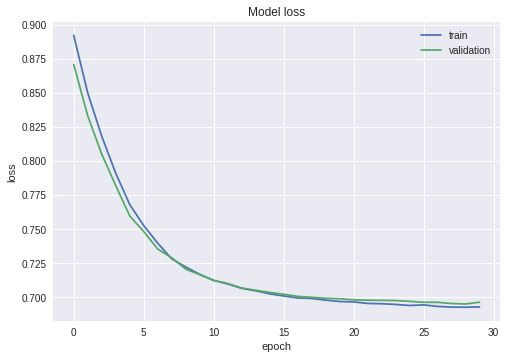

In [86]:
# The schema allows to see if the model was properly fitted
# that allows us to learn if the initial learning rate was appropriate
plt.title("Model loss")
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="validation")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [0]:
all_img_paths = sorted([img_path + current_img_name  for current_img_name  in listdir(img_path) ])
all_labels_paths = sorted([labels_path + current_label_name  for current_label_name  in listdir(labels_path) ])

In [0]:
all_img_nb = [all_img_paths[i].split("/")[-1].split(".")[0].split("im")[-1] for i in range(len(all_img_paths))]
all_labels_names = [all_labels_paths[i].split("/")[-1].split(".")[0] for i in range(len(all_labels_paths))]

LABELS PREPROCESSING 

ADD labelled Images

In [0]:
img_labels = {}
for current_label in range(len(all_labels_paths)):
    current_label_contents = pd.read_csv(all_labels_paths[current_label])
    current_label_img_nb = sorted(np.append(list(current_label_contents), current_label_contents.get_values() ).tolist())
    for current_img in current_label_img_nb:
        if( current_img not in img_labels.keys()):
            img_labels[current_img] = np.zeros(len(all_labels_names))
        img_labels[current_img][current_label] = 1
        

ADD unlabelled images

In [0]:
def unmatched_set(a, b):
    return [[a_i for a_i in a if a_i not in b], [b_i for b_i in b if b_i not in a]]

Get disjoined sets of unlabelled images and inexistent labelled images .

In [0]:
unmatched_set_images = unmatched_set( list(img_labels.keys()) , np.array(all_img_nb))

In [0]:
for current_unlab_img in unmatched_set_images[1]:
    img_labels[current_unlab_img] = np.zeros(len(all_labels_names))

IMAGES PREPROCESSING

There are 2 kinds of pictures :  
  - the first kind : The shapes equal to (128, 128, 3)
  - the second kind : The shapes equal to (128, 128)
  

In [0]:
img_shape = {}
for current_img_path in all_img_paths:
    current_img_vector =  plt.imread( current_img_path )
    
    #if (str(str(current_img_vector.shape)) == "(128, 128)"):
    #    print(current_img_vector.shape, current_img_path)
    #    unicolor_name = current_img_path
    #    unicolor = current_img_vector
    if(str(current_img_vector.shape) not in img_shape.keys()):
        img_shape[str(current_img_vector.shape)] = []
    img_shape[str(current_img_vector.shape)].append(current_img_path)

In [28]:
img_shape.keys()

dict_keys(['(128, 128, 3)', '(128, 128)'])

In [0]:
?plt.imread

RGB images

In [0]:
img_vector_3 = {}
#To process with all images, don't forget to remove "[:10]"
for current_img_path in img_shape["(128, 128, 3)"][:1024]:
    I =  plt.imread( current_img_path )
    modified_current_img_vector = np.array([I[:,:,0], I[:,:,1], I[:,:,2]])
    img_vector_3[current_img_path.split("/")[-1].split(".")[0].split("im")[-1]] = modified_current_img_vector


Grey images

In [0]:
img_vector_1 = {}

for current_img_path in img_shape["(128, 128)"]:
    current_img_vector =  plt.imread( current_img_path )
    #Do we have to reshape to (128*128) or (1,128*128) ?
    img_vector_1[current_img_path.split("/")[-1].split(".")[0].split("im")[-1]] = np.reshape(current_img_vector, (1,128,128))


In [32]:
img_vector_1

{'10034': array([[[ 11,  15,  12, ...,  16,  14,  16],
         [ 11,  14,  12, ...,  16,  13,  14],
         [ 11,  14,  12, ...,  15,  13,  14],
         ...,
         [  6,  11,   8, ...,  11,   5,   4],
         [  6,   8,   9, ...,  38,  51,  67],
         [  7,   6,  10, ..., 105,  84,  72]]], dtype=uint8),
 '1005': array([[[ 72,  67, 129, ...,   7,   6,   6],
         [ 89,  71,  64, ...,   8,  16,  11],
         [ 70,  80, 108, ...,  23,  34,  24],
         ...,
         [ 36,  16,  11, ..., 122, 136,  75],
         [ 46,  34,  31, ..., 112, 156,  98],
         [ 69,  62,  53, ...,  80, 142, 119]]], dtype=uint8),
 '10064': array([[[ 8,  3,  3, ...,  1,  2,  3],
         [ 3,  4,  0, ...,  3,  5,  5],
         [ 0,  4,  4, ...,  1,  2,  1],
         ...,
         [ 2,  2,  4, ..., 35, 31, 31],
         [ 4,  4,  2, ..., 65, 54, 43],
         [ 1,  3,  3, ..., 29, 20,  3]]], dtype=uint8),
 '1007': array([[[  8,   9,   5, ...,  14,  10,  11],
         [  5,  13,  10, ...,  14,  13

In [0]:
nb_img_vector_3 = len(img_vector_3.keys())

Create train dataset and test dataset from 3 dimention images

In [0]:

batch_size = 64

img_names = rd.sample(list(img_vector_3.keys()), nb_img_vector_3)
train_img_name = img_names[ :int(nb_img_vector_3 * 0.8)]
test_img_name = img_names[ int(nb_img_vector_3 * 0.8):]


X_Train = torch.from_numpy(np.array([ [ img_vector_3[ train_img_name[id_name*batch_size + id_batch]]  for id_batch in range(batch_size) ] for id_name in range(int(len(train_img_name)/batch_size))]))
y_Train = torch.from_numpy(np.array([ [ img_labels[   train_img_name[id_name*batch_size + id_batch]]  for id_batch in range(batch_size) ]for id_name in range(int(len(train_img_name)/batch_size))]))

X_Test = torch.from_numpy(np.array([ [ img_vector_3[ test_img_name[id_name*batch_size + id_batch]]  for id_batch in range(batch_size) ] for id_name in range(int(len(test_img_name)/batch_size))]))
y_Test = torch.from_numpy(np.array([ [ img_labels[   test_img_name[id_name*batch_size + id_batch]]  for id_batch in range(batch_size) ]for id_name in range(int(len(test_img_name)/batch_size))]))

X_Train = X_Train.type('torch.FloatTensor')
y_Train = y_Train.type('torch.FloatTensor')
X_Test = X_Test.type('torch.FloatTensor')
y_Test = y_Test.type('torch.FloatTensor')


In [35]:
print(X_Train.shape)
print(y_Train.shape)
print(X_Test.shape)
print(y_Test.shape)

torch.Size([12, 64, 3, 128, 128])
torch.Size([12, 64, 14])
torch.Size([3, 64, 3, 128, 128])
torch.Size([3, 64, 14])


In [36]:
X_Test.shape

torch.Size([3, 64, 3, 128, 128])

In [37]:
X_Test[0].shape

torch.Size([64, 3, 128, 128])

In [0]:
train_loader = zip(X_Train, y_Train)
test_loader = zip(X_Test, y_Test)

In [39]:
for  batch_idx, (data, target) in enumerate(train_loader) :
    print(data.shape)
    print(target.shape)
    print(batch_idx)

torch.Size([64, 3, 128, 128])
torch.Size([64, 14])
0
torch.Size([64, 3, 128, 128])
torch.Size([64, 14])
1
torch.Size([64, 3, 128, 128])
torch.Size([64, 14])
2
torch.Size([64, 3, 128, 128])
torch.Size([64, 14])
3
torch.Size([64, 3, 128, 128])
torch.Size([64, 14])
4
torch.Size([64, 3, 128, 128])
torch.Size([64, 14])
5
torch.Size([64, 3, 128, 128])
torch.Size([64, 14])
6
torch.Size([64, 3, 128, 128])
torch.Size([64, 14])
7
torch.Size([64, 3, 128, 128])
torch.Size([64, 14])
8
torch.Size([64, 3, 128, 128])
torch.Size([64, 14])
9
torch.Size([64, 3, 128, 128])
torch.Size([64, 14])
10
torch.Size([64, 3, 128, 128])
torch.Size([64, 14])
11


random NN

In [40]:

class Net(nn.Module):
    def __init__(self ):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.mp = nn.MaxPool2d(2)
        self.do = nn.Dropout(p=0.5)
        self.bn1 = nn.BatchNorm1d(num_features=18000)
        self.fc1 = nn.Linear(18000, 240)
        self.fc2 = nn.Linear(240, 120)
        self.fcout = nn.Linear(120, 14)
        
    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp(self.conv1(x)))
        x = F.relu(self.mp(self.conv2(x)))
        x = x.view(in_size, -1)  # flatten the tensor
        x = self.do(x)
        x =  F.relu(self.bn1(x))
        x = F.relu((self.fc1(x)))
        x = F.relu((self.fc2(x)))
        x = F.log_softmax(self.fcout(x))
        return x
    
    
model = Net( )#.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5) 
criterion = nn.CrossEntropyLoss()  
#criterion = nn.BCELoss
print(model)

Net(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (do): Dropout(p=0.5)
  (bn1): BatchNorm1d(18000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=18000, out_features=240, bias=True)
  (fc2): Linear(in_features=240, out_features=120, bias=True)
  (fcout): Linear(in_features=120, out_features=14, bias=True)
)


Forward

In [41]:
model.forward(X_Train[0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[-2.6356, -2.7033, -2.5611, -2.5944, -2.6164, -2.6539, -2.7160, -2.7650,
         -2.7305, -2.5867, -2.5827, -2.6628, -2.6888, -2.4873],
        [-2.6502, -2.7235, -2.5829, -2.5481, -2.6687, -2.6629, -2.6615, -2.7280,
         -2.6754, -2.6017, -2.6234, -2.6153, -2.6993, -2.5299],
        [-2.7033, -2.6695, -2.5515, -2.5933, -2.6888, -2.6657, -2.6602, -2.7050,
         -2.6784, -2.5806, -2.6111, -2.6807, -2.6973, -2.4900],
        [-2.6996, -2.6896, -2.5973, -2.5882, -2.6826, -2.6190, -2.6479, -2.7416,
         -2.6802, -2.6345, -2.5997, -2.6418, -2.6687, -2.4827],
        [-2.7269, -2.6826, -2.6190, -2.5561, -2.6894, -2.6584, -2.6857, -2.7345,
         -2.6219, -2.5884, -2.6146, -2.6623, -2.6591, -2.4792],
        [-2.6674, -2.6558, -2.5560, -2.5894, -2.6797, -2.6573, -2.6639, -2.7473,
         -2.6979, -2.5855, -2.5922, -2.6472, -2.6773, -2.5509],
        [-2.6701, -2.6455, -2.5748, -2.6171, -2.6727, -2.6554, -2.7219, -2.6828,
         -2.6686, -2.5684, -2.5930, -2.6777, -2.6

In [0]:
def train(epoch,trainv, log_interval=100):
    # Set model to training mode
    model.train()
    train_loss = 0
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        #data = data.to(device)
        #target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data.type("torch.FloatTensor"))

        # Calculate loss
        loss = criterion(output, target)
        train_loss += loss.data.item()
        
        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
    trainv.append( train_loss / float(len(train_loader)))

In [43]:
list(train_loader)

[]

In [0]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        #data = data.to(device)
        #target = target.to(device)
        
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))

In [45]:
%%time
epochs = 2

lossv, accv, trainv = [], [], []
for epoch in range(1, epochs + 1):
    train(epoch, trainv)
    #validate(lossv, accv)

TypeError: ignored

## Save your model

It might be useful to save your model if you want to continue your work later, or use it for inference later.

In [0]:
torch.save(model.state_dict(), 'model.pkl')

The model file should now be visible in the "Home" screen of the jupyter notebooks interface.  There you should be able to select it and press "download".  [See more here on how to load the model back](https://github.com/pytorch/pytorch/blob/761d6799beb3afa03657a71776412a2171ee7533/docs/source/notes/serialization.rst) if you want to continue training later.

## Download test set

The testset will be made available during the last week before the deadline and can be downloaded in the same way as the training set.

## Predict for test set

You should return your predictions for the test set in a plain text file.  The text file contains one row for each test set image.  Each row contains a binary prediction for each label (separated by a single space), 1 if it's present in the image, and 0 if not. The order of the labels is as follows (alphabetic order of the label names):

    baby bird car clouds dog female flower male night people portrait river sea tree

An example row could like like this if your system predicts the presense of a bird and clouds:

    0 1 0 1 0 0 0 0 0 0 0 0 0 0
    
The order of the rows should be according to the numeric order of the image numbers.  In the test set, this means that the first row refers to image `im20001.jpg`, the second to `im20002.jpg`, and so on.

If you have the prediction output matrix prepared in `y` you can use the following function to save it to a text file.

In [0]:
np.savetxt('results.txt', y, fmt='%d')